In [1]:
from iris import time, cube
import cis
from cis import read_data, read_data_list, get_variables, data_io
from cis.data_io import gridded_data
from cis.data_io.gridded_data import make_from_cube
from cis.time_util import PartialDateTime
from cis import plotting
from cis.plotting import plot
from cis.plotting.plot import drawbluemarble, multilayer_plot, taylor_plot

import os
from datetime import datetime
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import copy
from flight_py_tools import FAAM

from dateutil.relativedelta import relativedelta
import numpy as np
import numpy.ma as ma
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)


In [2]:
# Directory containing raw aircraft data and names of variables to plot
inputdir1='/shared/netscratch/mrr32/Flight_work/Flights/'
varname1='O3_TECO' ; source1='FAAM' ; variable1='Ozone' ; units1='(ppbv)'
# Position of date characters in the filename string
# Plugin to be used by cis.read_data
aircraft_plugin='FAAM'
# Directory containing model data on flight track and names of variables to plot
inputdir2='/shared/netscratch/mrr32/Flight_work/Outdir/'
inputdir3='/shared/netscratch/mrr32/Flight_work/Outdir_75/'
inputdir4='/shared/netscratch/mrr32/Flight_work/Outdir_50/'
inputdir5='/shared/netscratch/mrr32/Flight_work/Outdir_25/'

varname2='m01s51i001' ; source2='UKCA' ; variable2='Ozone' ; units2='(ppbv)'
stash='51001' ; cfactor=1.e9/1.657
# Directory to store plots
outdir='/home/am2688/nethome/Plots/'
# colors for colorbars (from https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3):
# Diverging: blue to red (9 colours)
blue_to_red =['#313695','#4575b4','#74add1','#abd9e9','#ffffff','#fdae61','#f46d43','#d73027','#a50026'] 
# Diverging: green to magenta (9 colours)
green_to_magenta = ['#276419','#4d9221','#7fbc41','#b8e186','#ffffff','#f1b6da','#de77ae','#c51b7d','#8e0152']
# Sequential: yellow to red (7 colours)
yellow_to_red = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
my_colours= ['#a6cee3','#1f78b4','#b2df8a','#33a02c'] #colourblind+qualitative safe, but included greens
final_colours= ['#ca0020','#f4a582','#92c5de','#0571b0'] #colourblind safe + diverging
colour_100='#ca0020'
colour_75='#f4a582'
colour_50='#0571b0'
colour_25='#92c5de'

In [3]:
# Read all Obs
infile1=inputdir1+'*.nc'
obs=cis.read_data(infile1,varname1,product='FAAM')
# Read all Model data 100%
infile2=inputdir2+'*'+'stash'+stash+'*'
mod=cis.read_data(infile2,varname2,product='FAAM')
# Read all Model data 75%
infile3=inputdir3+'*'+'stash'+stash+'*'
mod_75=cis.read_data(infile3,varname2,product='FAAM')
# Read all Model data 50%
infile4=inputdir4+'*'+'stash'+stash+'*'
mod_50=cis.read_data(infile4,varname2,product='FAAM')
# Read all Model data 25%
infile5=inputdir5+'*'+'stash'+stash+'*'
mod_25=cis.read_data(infile5,varname2,product='FAAM')

In [4]:
# Extract np arrays from variables masked arrays
# This is necessary to avoid errors whilst operating on the variables
obs.data=ma.getdata(obs.data)
mod.data=ma.getdata(mod.data)
for cc in range(len(obs._coords)) :
    obs._coords[cc].data=ma.getdata(obs._coords[cc].data)
    mod._coords[cc].data=ma.getdata(mod._coords[cc].data)
    mod_75._coords[cc].data=ma.getdata(mod_75._coords[cc].data)
    mod_50._coords[cc].data=ma.getdata(mod_50._coords[cc].data)
    mod_25._coords[cc].data=ma.getdata(mod_25._coords[cc].data)

In [5]:
#remove negative and nans using masked arrays
obs.data=ma.masked_less_equal(obs.data, 3)
obs.data=ma.masked_invalid(obs.data)
#obs.data=ma.masked_greater_equal(obs.data, 90)
# Convert model data to ppbv
mod.data=mod.data*cfactor
mod_75.data=mod_75.data*cfactor
mod_50.data=mod_50.data*cfactor
mod_25.data=mod_25.data*cfactor

mod.data=ma.masked_invalid(mod.data)
mod_75.data=ma.masked_invalid(mod_75.data)
mod_50.data=ma.masked_invalid(mod_50.data)
mod_25.data=ma.masked_invalid(mod_25.data)

In [6]:
### mean vertical profile
#choose region of atmosphere
region_obs= obs.subset(y=[-30,30])
region_mod= mod.subset(y=[-30,30])
region_mod_75= mod_75.subset(y=[-30,30])
region_mod_50= mod_50.subset(y=[-30,30])
region_mod_25= mod_25.subset(y=[-30,30])


In [7]:

max_altitude=11000
band_size = 1000
levels=(max_altitude/band_size)
n_lev=round(levels)
average_data_obs = [0]*n_lev
average_data_mod = [0]*n_lev
average_data_mod_75 = [0]*n_lev
average_data_mod_50 = [0]*n_lev
average_data_mod_25 = [0]*n_lev

SD_data_obs = [0]*n_lev
SD_data_mod = [0]*n_lev
SD_data_mod_75 = [0]*n_lev
SD_data_mod_50 = [0]*n_lev
SD_data_mod_25 = [0]*n_lev

for z_band in range(n_lev):
    print(z_band)
    lower=z_band*band_size
    upper=(z_band+1)*band_size
    average_data_obs[z_band]=np.ma.mean(region_obs.subset(z=[lower,upper]).data)
    average_data_mod[z_band]=np.ma.mean(region_mod.subset(z=[lower,upper]).data)
    average_data_mod_75[z_band]=np.ma.mean(region_mod_75.subset(z=[lower,upper]).data)
    average_data_mod_50[z_band]=np.ma.mean(region_mod_50.subset(z=[lower,upper]).data)
    average_data_mod_25[z_band]=np.ma.mean(region_mod_25.subset(z=[lower,upper]).data)
    
    SD_data_obs[z_band]=np.ma.std(region_obs.subset(z=[lower,upper]).data)
    SD_data_mod[z_band]=np.ma.std(region_mod.subset(z=[lower,upper]).data)
    SD_data_mod_75[z_band]=np.ma.std(region_mod_75.subset(z=[lower,upper]).data)
    SD_data_mod_50[z_band]=np.ma.std(region_mod_50.subset(z=[lower,upper]).data)
    SD_data_mod_25[z_band]=np.ma.std(region_mod_25.subset(z=[lower,upper]).data)

#altitude= [500,1500,2500,3500,4500,5500,6500,7500,8500,9500,10500,11500]
altitude=np.linspace(0.5*band_size,max_altitude-0.5*band_size,n_lev)
#print(average_data)
altitude_km = altitude/1000

0
1
2
3
4
5
6
7
8
9
10


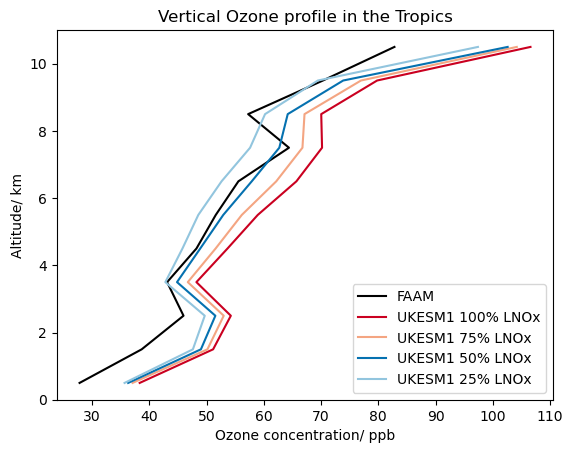

In [9]:
#plotting all 5 vertical O3 profiles----- happy with code
plt.plot(average_data_obs, altitude_km,'black', label='FAAM')
plt.plot(average_data_mod, altitude_km, colour_100, label="UKESM1 100% LNOx")
plt.plot(average_data_mod_75, altitude_km, colour_75, label="UKESM1 75% LNOx")
plt.plot(average_data_mod_50, altitude_km, colour_50, label="UKESM1 50% LNOx")
plt.plot(average_data_mod_25, altitude_km, colour_25, label="UKESM1 25% LNOx")

plt.legend(loc='lower right')
plt.xlabel('Ozone concentration/ ppb')
plt.ylabel('Altitude/ km')
plt.title('Vertical Ozone profile in the Tropics')
#plt.ylim([0,13000])
#plt.xlim([0,250])
#print(altitude)
#plt.text(0.025, 0.95, 'a)', fontsize=15, color='black', transform=plt.transAxes)
plt.savefig(outdir+'O3_vp_all4.png',dpi=300,bbox_inches='tight')

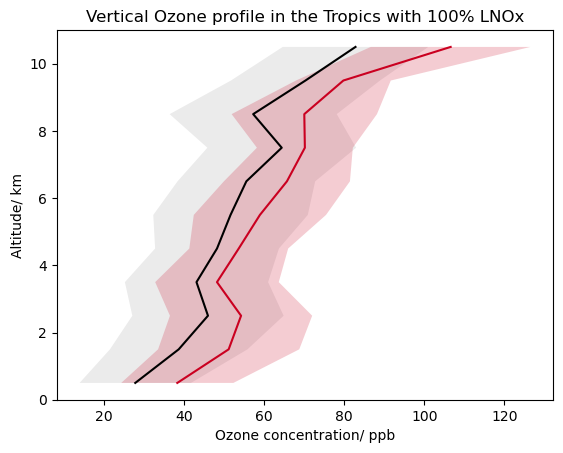

In [11]:
#plotting obs vs mod vertical profile with envelopes using SD----- happy with code
#plt.scatter(average_data_obs, altitude , marker='x', s=20)
obs_minus = np.array(average_data_obs)-np.array(SD_data_obs)
obs_plus = np.array(average_data_obs)+np.array(SD_data_obs)

mod_minus = np.array(average_data_mod)-np.array(SD_data_mod)
mod_plus = np.array(average_data_mod)+np.array(SD_data_mod)

plt.plot(average_data_obs, altitude_km,'black', label='FAAM')
plt.fill_betweenx(altitude_km,obs_minus,obs_plus,alpha=0.08, color='black', edgecolor=None)

plt.plot(average_data_mod, altitude_km, colour_100, label='FAAM')
plt.fill_betweenx(altitude_km,mod_minus,mod_plus,alpha=0.2, color=colour_100, edgecolor=None)

plt.xlabel('Ozone concentration/ ppb')
plt.ylabel('Altitude/ km')
plt.title('Vertical Ozone profile in the Tropics with 100% LNOx')
#plt.ylim([0,13000])
#plt.xlim([0,250])
#print(altitude)
plt.savefig(outdir+'O3_vpenv_100.png',dpi=300,bbox_inches='tight')

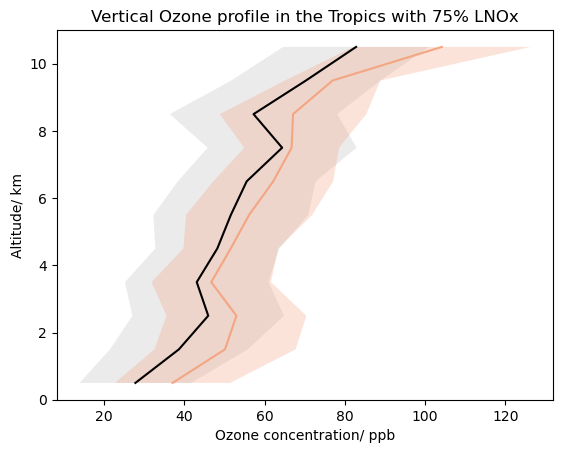

In [12]:
#plotting obs vs mod_75 vertical profile with envelopes using SD----- happy with code
#plt.scatter(average_data_obs, altitude , marker='x', s=20)
obs_minus = np.array(average_data_obs)-np.array(SD_data_obs)
obs_plus = np.array(average_data_obs)+np.array(SD_data_obs)

mod_75_minus = np.array(average_data_mod_75)-np.array(SD_data_mod_75)
mod_75_plus = np.array(average_data_mod_75)+np.array(SD_data_mod_75)

plt.plot(average_data_obs, altitude_km,'black', label='FAAM')
plt.fill_betweenx(altitude_km,obs_minus,obs_plus,alpha=0.08, color='black', edgecolor=None)

plt.plot(average_data_mod_75, altitude_km, colour_75, label='FAAM')
plt.fill_betweenx(altitude_km,mod_75_minus,mod_75_plus,alpha=0.3, color=colour_75, edgecolor=None)

plt.xlabel('Ozone concentration/ ppb')
plt.ylabel('Altitude/ km')
plt.title('Vertical Ozone profile in the Tropics with 75% LNOx')
#plt.ylim([0,13000])
#plt.xlim([0,250])
#print(altitude)
plt.savefig(outdir+'O3_vpenv_75.png',dpi=300,bbox_inches='tight')

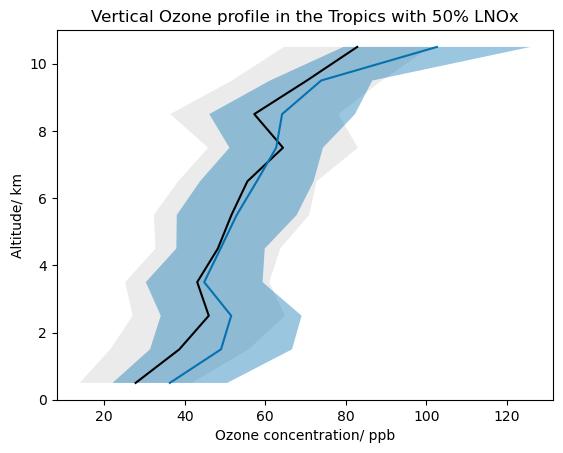

In [13]:
#plotting obs vs mod_50 vertical profile with envelopes using SD----- happy with code
#plt.scatter(average_data_obs, altitude , marker='x', s=20)
obs_minus = np.array(average_data_obs)-np.array(SD_data_obs)
obs_plus = np.array(average_data_obs)+np.array(SD_data_obs)

mod_50_minus = np.array(average_data_mod_50)-np.array(SD_data_mod_50)
mod_50_plus = np.array(average_data_mod_50)+np.array(SD_data_mod_50)

plt.plot(average_data_obs, altitude_km,'black', label='FAAM')
plt.fill_betweenx(altitude_km,obs_minus,obs_plus,alpha=0.08, color='black', edgecolor=None)

plt.plot(average_data_mod_50, altitude_km, colour_50, label='FAAM')
plt.fill_betweenx(altitude_km,mod_50_minus,mod_50_plus,alpha=0.4, color=colour_50, edgecolor=None)

plt.xlabel('Ozone concentration/ ppb')
plt.ylabel('Altitude/ km')
plt.title('Vertical Ozone profile in the Tropics with 50% LNOx')
#plt.ylim([0,13000])
#plt.xlim([0,250])
#print(altitude)
plt.savefig(outdir+'O3_vpenv_50.png',dpi=300,bbox_inches='tight')

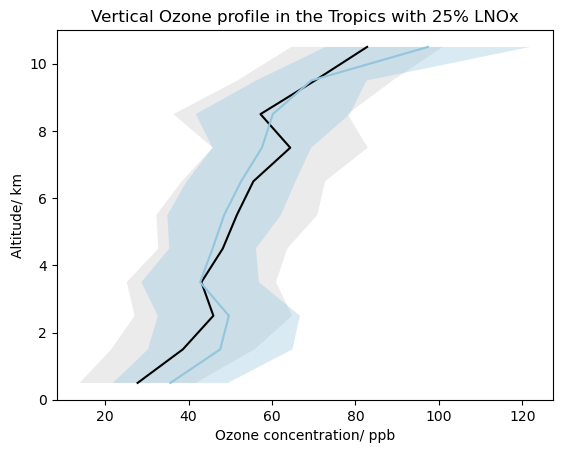

In [14]:
#plotting obs vs mod_25 vertical profile with envelopes using SD----- happy with code
#plt.scatter(average_data_obs, altitude , marker='x', s=20)
obs_minus = np.array(average_data_obs)-np.array(SD_data_obs)
obs_plus = np.array(average_data_obs)+np.array(SD_data_obs)

mod_25_minus = np.array(average_data_mod_25)-np.array(SD_data_mod_25)
mod_25_plus = np.array(average_data_mod_25)+np.array(SD_data_mod_25)

plt.plot(average_data_obs, altitude_km,'black', label='FAAM')
plt.fill_betweenx(altitude_km,obs_minus,obs_plus,alpha=0.08, color='black', edgecolor=None)

#plt.plot(average_data_mod_25, altitude_km, colour_25, linewidth=2, label='FAAM')
plt.plot(average_data_mod_25, altitude_km, colour_25, label='FAAM')
plt.fill_betweenx(altitude_km,mod_25_minus,mod_25_plus,alpha=0.35, color=colour_25, edgecolor=None)

plt.xlabel('Ozone concentration/ ppb')
plt.ylabel('Altitude/ km')
plt.title('Vertical Ozone profile in the Tropics with 25% LNOx')
#plt.ylim([0,13000])
#plt.xlim([0,250])
#print(altitude)
plt.savefig(outdir+'O3_vpenv_25.png',dpi=300,bbox_inches='tight')

In [ ]:
len((region_obs.subset(z=[8000,9000]).data))

In [ ]:
### mean vertical profile
#choose region of atmosphere
max_altitude=11000
band_size = 1000
levels=(max_altitude/band_size)
n_lev=round(levels)
number_points_obs= [0]*n_lev
number_points_mod= [0]*n_lev

for z_band in range(n_lev):
    print(z_band)
    lower=z_band*band_size
    upper=(z_band+1)*band_size
    number_points_obs[z_band]=len(region_obs.subset(z=[lower,upper]).data)
    number_points_mod[z_band]=len(region_mod.subset(z=[lower,upper]).data)

#altitude= [500,1500,2500,3500,4500,5500,6500,7500,8500,9500,10500,11500]
altitude=np.linspace(0.5*band_size,max_altitude-0.5*band_size,n_lev)
#print(average_data)
altitude_km = altitude/1000
number_points= np.array(number_points_obs)/1000

In [ ]:
plt.barh(altitude_km, number_points, height=0.8, align='center')
plt.xlabel('Number of points (thousands)')
plt.ylabel('Altitude /km')
plt.title('Frequency of points in each vertical band for tropics')
plt.ylim([0,11])

In [ ]:
# Define Axes
ax1=fig.add_subplot(3, 2, 1)
ax2=fig.add_subplot(3, 2 ,2)
ax3=fig.add_subplot(3, 2, 3)
ax4=fig.add_subplot(3, 2, 4)
ax5=fig.add_subplot(3, 2, 5)
ax6=fig.add_subplot(3, 2, 6)

# Then plot as usual
ax1.plot(.....)ax2.scatter(....)etc.

